Pooled rows total: n=16286 across timesteps=[180, 190, 200, 210]
Cluster/model features (common across all timesteps): ['curvature', 'dcurvdx', 'dcurvdy', 'du_ndx', 'du_ndy', 'du_tdx', 'du_tdy', 'normal_strain_rate', 'tangential_strain_rate', 'u_n', 'u_t', 'vorticity']
After dropna on features+target: n=16286

Global GMM AIC: 1590.28
Global GMM BIC: 3684.15

Global cluster summary (pooled):
 cluster    n  sd_mean   sd_std  conf_mean
       0 3889 1.224651 0.097574   0.998600
       1 8434 0.757599 0.516902   0.999194
       2 3963 1.224810 0.098277   0.998168

Cluster occupancy / Sd mean by timestep:
 timestep  cluster    n  sd_mean  conf_mean
      180        0  983 1.224206   0.998808
      180        1 2304 0.716413   0.999248
      180        2  946 1.229561   0.997675
      190        0 1030 1.207175   0.998754
      190        1 1909 0.729320   0.998866
      190        2  932 1.223279   0.998408
      200        0  923 1.239345   0.998216
      200        1 2162 0.764175   0.999

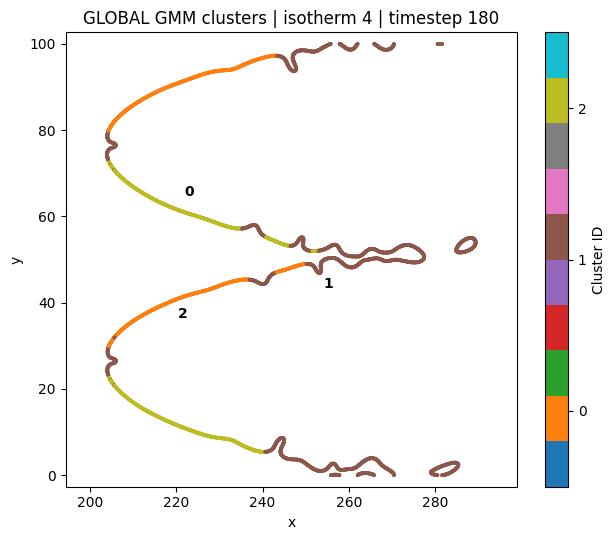

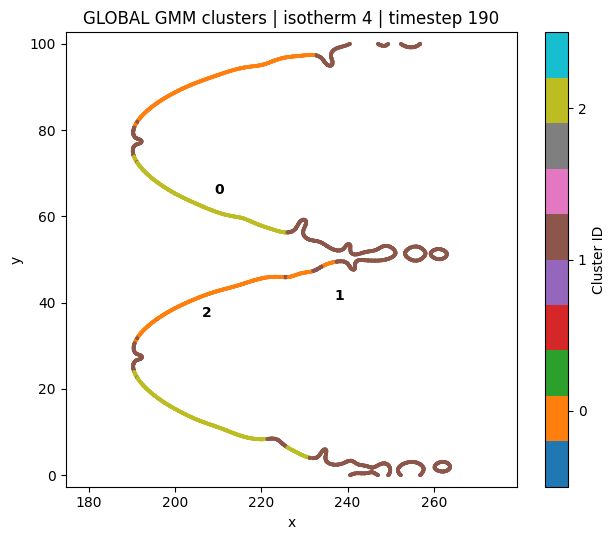

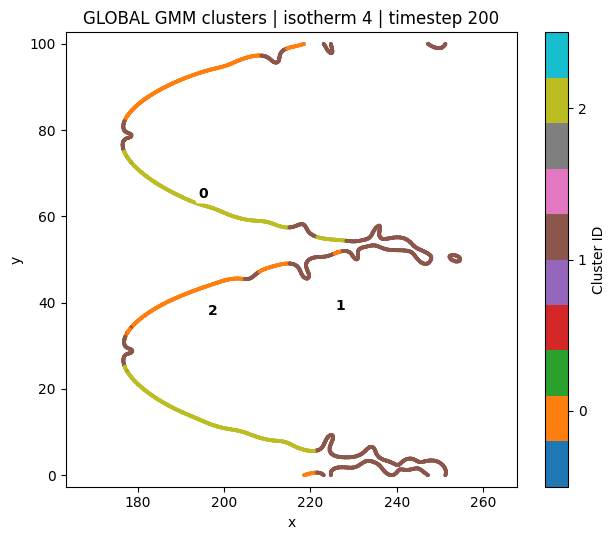

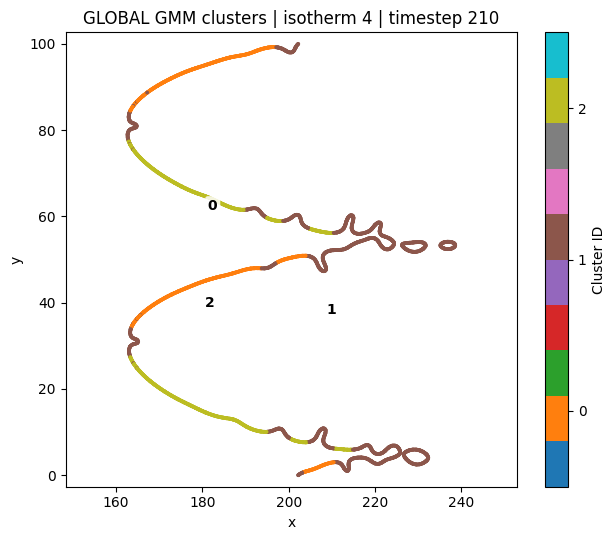


--- Cluster 0 (GLOBAL) | n=3889 ---
R^2=0.9944 | RMSE=7.467875e-03
Importance method: shap
Top features:
  01. du_ndx  (4.1083e-02)
  02. du_ndy  (2.5291e-02)
  03. u_t  (2.0021e-02)
  04. du_tdx  (8.4785e-03)
  05. normal_strain_rate  (2.9384e-03)
  06. dcurvdx  (1.9396e-03)
  07. tangential_strain_rate  (1.8461e-03)
  08. du_tdy  (1.5241e-03)
  09. curvature  (1.3147e-03)
  10. vorticity  (9.4404e-04)
  11. dcurvdy  (8.2804e-04)
  12. u_n  (7.4366e-04)


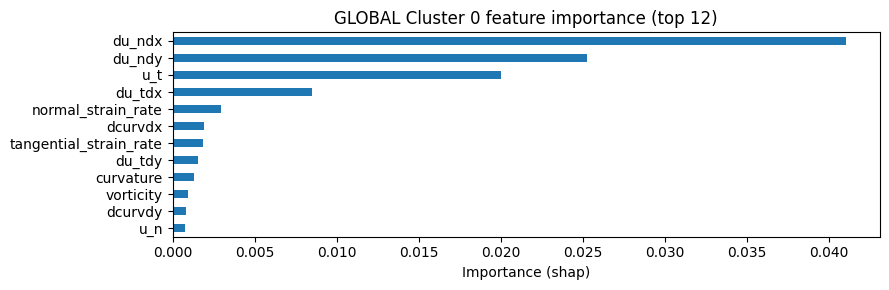


--- Cluster 1 (GLOBAL) | n=8434 ---
R^2=0.9647 | RMSE=9.555902e-02
Importance method: shap
Top features:
  01. curvature  (2.1202e-01)
  02. du_ndx  (1.3754e-01)
  03. vorticity  (9.9766e-02)
  04. tangential_strain_rate  (7.7284e-02)
  05. du_ndy  (4.4789e-02)
  06. dcurvdx  (3.3317e-02)
  07. u_n  (3.3215e-02)
  08. du_tdy  (2.7637e-02)
  09. dcurvdy  (2.3342e-02)
  10. u_t  (1.4820e-02)
  11. du_tdx  (1.3233e-02)
  12. normal_strain_rate  (6.9400e-03)


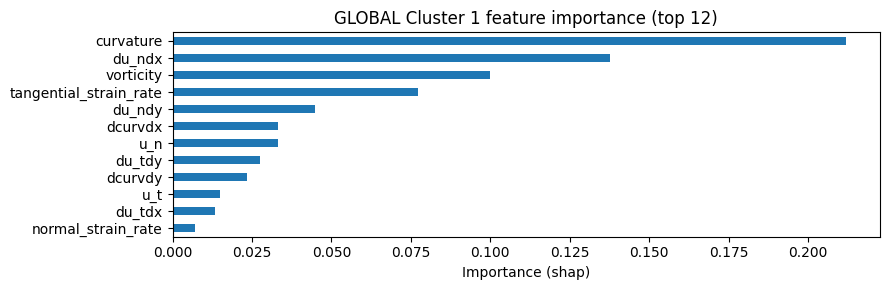


--- Cluster 2 (GLOBAL) | n=3963 ---
R^2=0.9918 | RMSE=8.980297e-03
Importance method: shap
Top features:
  01. du_tdx  (4.7086e-02)
  02. du_ndy  (2.2406e-02)
  03. du_ndx  (1.7772e-02)
  04. u_t  (1.2290e-02)
  05. curvature  (2.1969e-03)
  06. vorticity  (1.6664e-03)
  07. dcurvdx  (1.4443e-03)
  08. du_tdy  (1.2271e-03)
  09. dcurvdy  (1.1783e-03)
  10. u_n  (1.0845e-03)
  11. normal_strain_rate  (1.0196e-03)
  12. tangential_strain_rate  (5.9052e-04)


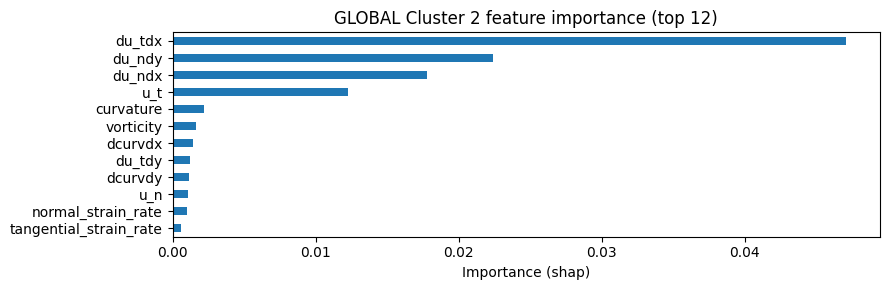


Per-cluster model metrics (GLOBAL clusters):
 cluster    n       r2     rmse importance_method
       0 3889 0.994361 0.007468              shap
       1 8434 0.964744 0.095559              shap
       2 3963 0.991774 0.008980              shap


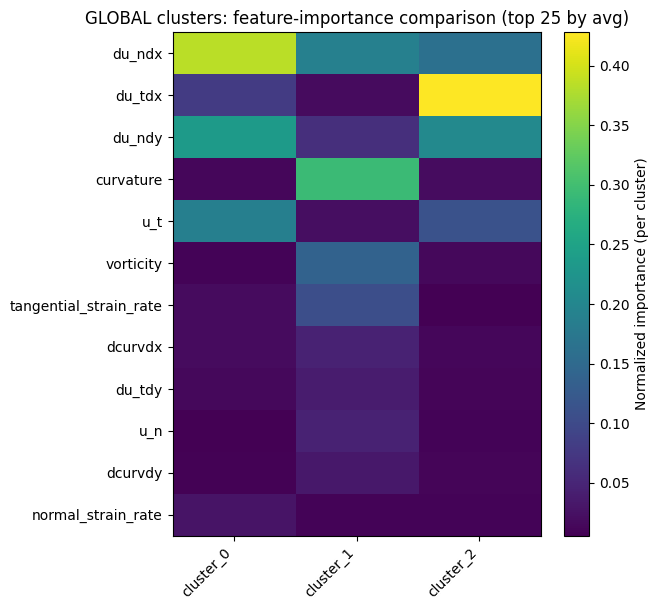


Top features (normalized importance per cluster):
                        cluster_0  cluster_1  cluster_2
du_ndx                     0.3841     0.1900     0.1616
du_tdx                     0.0793     0.0183     0.4282
du_ndy                     0.2365     0.0619     0.2038
curvature                  0.0123     0.2929     0.0200
u_t                        0.1872     0.0205     0.1118
vorticity                  0.0088     0.1378     0.0152
tangential_strain_rate     0.0173     0.1068     0.0054
dcurvdx                    0.0181     0.0460     0.0131
du_tdy                     0.0143     0.0382     0.0112
u_n                        0.0070     0.0459     0.0099
dcurvdy                    0.0077     0.0322     0.0107
normal_strain_rate         0.0275     0.0096     0.0093


In [1]:
from __future__ import annotations

from flamekit.io_fronts import Case, load_fronts
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import List, Dict, Tuple

from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.inspection import permutation_importance


# =========================
# USER SETTINGS
# =========================

BASE_DIR = Path("../data/isocontours")
PHI = 0.40
LAT_SIZE = "100"
POST = True

# Global clustering timesteps
TIME_STEPS = [180, 190, 200, 210]

TARGET_VAR = "DW_FDS"
ISOLEVEL = 4

CLUSTER_ON_SPATIAL = False  # if True, x,y,z can be included as clustering features

COLS_TO_INCLUDE = {
    "curvature",
    "dcurvdx",
    "dcurvdy",
    "tangential_strain_rate",
    "normal_strain_rate",
    "vorticity",
    "u_n",
    "u_t",
    "du_ndx",
    "du_ndy",
    "du_tdx",
    "du_tdy",
}

N_CLUSTERS = 3

GMM_PARAMS = dict(
    covariance_type="full",
    reg_covar=1e-4,     # increased a bit to reduce numerical collapse across pooled data
    max_iter=500,
    n_init=20,
    init_params="kmeans",
    random_state=0,
)

MIN_CLUSTER_SAMPLES = 50
TEST_SIZE = 0.25
RANDOM_STATE = 0

MODEL_PARAMS = dict(
    n_estimators=400,
    max_depth=None,
    random_state=RANDOM_STATE,
    n_jobs=-1,
)

TOPN_PRINT = 12
TOPN_HEATMAP = 25


# =========================
# Feature utilities
# =========================

def numeric_feature_list_from_include(df: pd.DataFrame, include: List[str]) -> List[str]:
    return [c for c in include if (c in df.columns) and pd.api.types.is_numeric_dtype(df[c])]


def labeled_cluster_plot_xy(dfc: pd.DataFrame, n_clusters: int, title: str):
    if "x" not in dfc.columns or "y" not in dfc.columns:
        return

    plt.figure(figsize=(6.5, 5.5))
    sc = plt.scatter(
        dfc["x"], dfc["y"],
        c=dfc["cluster"],
        s=3,
        cmap="tab10",
        vmin=-0.5,
        vmax=n_clusters - 0.5,
    )
    plt.axis("equal")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.title(title)

    cbar = plt.colorbar(sc, ticks=np.arange(n_clusters))
    cbar.set_label("Cluster ID")
    cbar.ax.set_yticklabels([str(i) for i in range(n_clusters)])

    centroids_xy = dfc.groupby("cluster")[["x", "y"]].mean().reset_index()
    for _, row in centroids_xy.iterrows():
        cl = int(row["cluster"])
        plt.text(
            row["x"], row["y"], str(cl),
            ha="center", va="center",
            fontsize=10, fontweight="bold",
            bbox=dict(boxstyle="round,pad=0.2", fc="white", alpha=0.85, ec="none"),
        )

    plt.tight_layout()
    plt.show()


# =========================
# Importance (SHAP preferred, fallback to permutation)
# =========================

def compute_importance(
    model,
    X_test: np.ndarray,
    y_test: np.ndarray,
    feature_names: List[str],
    prefer_shap: bool = True,
    random_state: int = 0,
) -> Tuple[pd.Series, str]:
    """
    Returns:
      importance: pd.Series indexed by feature_names
      method: "shap" or "permutation"
    """
    if prefer_shap:
        try:
            import shap  # type: ignore
            explainer = shap.TreeExplainer(model)
            shap_vals = explainer.shap_values(X_test)  # (n_samples, n_features)
            imp = np.mean(np.abs(shap_vals), axis=0)
            s = pd.Series(imp, index=feature_names).sort_values(ascending=False)
            return s, "shap"
        except Exception:
            pass

    pi = permutation_importance(
        model, X_test, y_test,
        n_repeats=10,
        random_state=random_state,
        n_jobs=-1,
        scoring="r2",
    )
    s = pd.Series(pi.importances_mean, index=feature_names).sort_values(ascending=False)
    return s, "permutation"


# ============================================================
# LOAD + GLOBAL CLUSTERING (Notebook cell style)
# ============================================================

# 1) Load and pool data across timesteps
dfs = []
feature_sets_per_t = []

include_for_cluster = list(COLS_TO_INCLUDE)
if CLUSTER_ON_SPATIAL:
    include_for_cluster = include_for_cluster + ["x", "y", "z"]

for ts in TIME_STEPS:
    CASE = Case(
        base_dir=BASE_DIR,
        phi=PHI,
        lat_size=LAT_SIZE,
        time_step=ts,
        post=POST,
    )

    fronts = load_fronts(CASE, [ISOLEVEL])
    if ISOLEVEL not in fronts:
        raise ValueError(f"ISOLEVEL {ISOLEVEL} not found for timestep {ts}")

    df_t = fronts[ISOLEVEL].copy()
    df_t["c_iso"] = float(ISOLEVEL)
    df_t["timestep"] = int(ts)

    if TARGET_VAR not in df_t.columns:
        raise ValueError(f"TARGET_VAR '{TARGET_VAR}' not found for timestep {ts}")

    # Candidate cluster features present in this timestep (numeric + in include list)
    feats_t = set(numeric_feature_list_from_include(df_t, include_for_cluster))
    feature_sets_per_t.append(feats_t)

    dfs.append(df_t)

df_all = pd.concat(dfs, ignore_index=True)

# 2) Enforce consistent feature space across all timesteps: intersection
cluster_features = sorted(set.intersection(*feature_sets_per_t))
if len(cluster_features) == 0:
    raise ValueError("No common numeric clustering features across all requested timesteps.")

# Model features (same as clustering features by default)
model_features = cluster_features
feature_names = list(model_features)

print(f"Pooled rows total: n={len(df_all)} across timesteps={TIME_STEPS}")
print(f"Cluster/model features (common across all timesteps): {cluster_features}")

# 3) Clean rows (require model_features + target)
dfc = df_all.dropna(subset=model_features + [TARGET_VAR]).copy()
print(f"After dropna on features+target: n={len(dfc)}")

# 4) Standardize globally (fit on pooled data)
Xc = dfc[cluster_features].to_numpy()
scaler = StandardScaler()
Xc_s = scaler.fit_transform(Xc)

# 5) Fit ONE global GMM and assign clusters
gmm = GaussianMixture(n_components=N_CLUSTERS, **GMM_PARAMS)
dfc["cluster"] = gmm.fit_predict(Xc_s)

probs = gmm.predict_proba(Xc_s)
dfc["cluster_conf"] = probs.max(axis=1)

print(f"\nGlobal GMM AIC: {gmm.aic(Xc_s):.2f}")
print(f"Global GMM BIC: {gmm.bic(Xc_s):.2f}")

# 6) Summary overall + per timestep
summary_global = (
    dfc.groupby("cluster")
    .agg(
        n=(TARGET_VAR, "size"),
        sd_mean=(TARGET_VAR, "mean"),
        sd_std=(TARGET_VAR, "std"),
        conf_mean=("cluster_conf", "mean"),
    )
    .reset_index()
    .sort_values("cluster")
)

print("\nGlobal cluster summary (pooled):")
print(summary_global.to_string(index=False))

summary_by_t = (
    dfc.groupby(["timestep", "cluster"])
    .agg(n=(TARGET_VAR, "size"), sd_mean=(TARGET_VAR, "mean"), conf_mean=("cluster_conf", "mean"))
    .reset_index()
    .sort_values(["timestep", "cluster"])
)

print("\nCluster occupancy / Sd mean by timestep:")
print(summary_by_t.to_string(index=False))

# Optional: plot clusters in xy for each timestep
for ts in TIME_STEPS:
    sub = dfc[dfc["timestep"] == ts]
    if len(sub) == 0:
        continue
    labeled_cluster_plot_xy(
        sub, N_CLUSTERS,
        title=f"GLOBAL GMM clusters | isotherm {ISOLEVEL} | timestep {ts}"
    )

# ============================================================
# Per-cluster models + SHAP (on pooled data)
# ============================================================

importances: Dict[int, pd.Series] = {}
metrics: List[dict] = []
used_method: Dict[int, str] = {}

for cl in range(N_CLUSTERS):
    sub = dfc[dfc["cluster"] == cl].copy()
    n_cl = len(sub)
    print(f"\n--- Cluster {cl} (GLOBAL) | n={n_cl} ---")

    if n_cl < MIN_CLUSTER_SAMPLES:
        print(f"Skipping (n < MIN_CLUSTER_SAMPLES={MIN_CLUSTER_SAMPLES})")
        continue

    X = sub[model_features].to_numpy()
    y = sub[TARGET_VAR].to_numpy()

    Xtr, Xte, ytr, yte = train_test_split(
        X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE
    )

    model = RandomForestRegressor(**MODEL_PARAMS)
    model.fit(Xtr, ytr)

    ypred = model.predict(Xte)
    r2 = r2_score(yte, ypred)
    rmse = float(np.sqrt(mean_squared_error(yte, ypred)))
    print(f"R^2={r2:.4f} | RMSE={rmse:.6e}")

    imp, method = compute_importance(
        model=model,
        X_test=Xte,
        y_test=yte,
        feature_names=feature_names,
        prefer_shap=True,
        random_state=RANDOM_STATE,
    )
    used_method[cl] = method
    importances[cl] = imp

    print(f"Importance method: {method}")
    print("Top features:")
    for i, (fname, val) in enumerate(imp.head(TOPN_PRINT).items(), 1):
        print(f"  {i:02d}. {fname}  ({val:.4e})")

    metrics.append(
        {"cluster": cl, "n": n_cl, "r2": float(r2), "rmse": rmse, "importance_method": method}
    )

    top = imp.head(TOPN_PRINT).iloc[::-1]
    plt.figure(figsize=(9, 3))
    top.plot(kind="barh")
    plt.xlabel(f"Importance ({method})")
    plt.title(f"GLOBAL Cluster {cl} feature importance (top {TOPN_PRINT})")
    plt.tight_layout()
    plt.show()

# Metrics table
if metrics:
    metrics_df = pd.DataFrame(metrics).sort_values("cluster")
    print("\nPer-cluster model metrics (GLOBAL clusters):")
    print(metrics_df.to_string(index=False))
else:
    print("\nNo clusters satisfied MIN_CLUSTER_SAMPLES; nothing trained.")

# Compare importances across clusters (heatmap)
if importances:
    trained_clusters = sorted(importances.keys())

    common_feats = set(feature_names)
    for cl in trained_clusters:
        common_feats = common_feats.intersection(importances[cl].index.tolist())
    common_feats = list(common_feats)

    imp_mat = pd.DataFrame(index=common_feats)
    for cl in trained_clusters:
        imp_mat[f"cluster_{cl}"] = importances[cl].reindex(common_feats).fillna(0.0)

    # Normalize per cluster
    imp_norm = imp_mat.copy()
    for col in imp_norm.columns:
        s = imp_norm[col].sum()
        if s > 0:
            imp_norm[col] /= s

    imp_norm["avg"] = imp_norm.mean(axis=1)
    top_feats = imp_norm.sort_values("avg", ascending=False).head(TOPN_HEATMAP).index
    heat = imp_norm.loc[top_feats, [c for c in imp_norm.columns if c != "avg"]]

    plt.figure(figsize=(1.2 * len(trained_clusters) + 3, 0.35 * len(top_feats) + 2))
    plt.imshow(heat.to_numpy(), aspect="auto")
    plt.xticks(np.arange(len(heat.columns)), heat.columns, rotation=45, ha="right")
    plt.yticks(np.arange(len(heat.index)), heat.index)
    plt.colorbar(label="Normalized importance (per cluster)")
    plt.title(f"GLOBAL clusters: feature-importance comparison (top {TOPN_HEATMAP} by avg)")
    plt.tight_layout()
    plt.show()

    print("\nTop features (normalized importance per cluster):")
    print(heat.round(4).to_string())
